In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('poster')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

from statsmodels.stats.outliers_influence import variance_inflation_factor    
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

import statsmodels.formula.api as smf

In [2]:
columnDict = pd.read_csv('./columnDict.csv')
columnDict.replace({'2B':'doubles', '3B': 'triples'}, inplace=True)
columnDict

,Column,Description
0,yearID,Year
1,lgID,League
2,teamID,Team
3,franchID,Franchise (links to TeamsFranchise table)
4,divID,Team's division
5,Rank,Position in final standings
6,G,Games played
7,GHome,Games played at home
8,W,Wins
9,L,Losses


In [3]:
df = pd.read_csv('./baseball/core/Teams.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 48 columns):
yearID            2835 non-null int64
lgID              2785 non-null object
teamID            2835 non-null object
franchID          2835 non-null object
divID             1318 non-null object
Rank              2835 non-null int64
G                 2835 non-null int64
Ghome             2436 non-null float64
W                 2835 non-null int64
L                 2835 non-null int64
DivWin            1290 non-null object
WCWin             654 non-null object
LgWin             2807 non-null object
WSWin             2478 non-null object
R                 2835 non-null int64
AB                2835 non-null int64
H                 2835 non-null int64
2B                2835 non-null int64
3B                2835 non-null int64
HR                2835 non-null int64
BB                2835 non-null int64
SO                2715 non-null float64
SB                2691 non-null float64
CS    

In [5]:
df['CG'].describe()

count    2835.000000
mean       49.976014
std        38.836412
min         0.000000
25%        13.000000
50%        45.000000
75%        77.000000
max       148.000000
Name: CG, dtype: float64

In [6]:
df = df[df["yearID"]>=1977]
df.drop('Rank', axis=1, inplace=True)
df.fillna(0, inplace=True)

In [7]:
def winPer(w, l):
    return w/(w+l)
df['winP'] = df.apply(lambda row : winPer(row['W'], row['L']), axis=1)

In [8]:
df.rename(columns={'2B':'doubles', '3B': 'triples'}, inplace=True)

In [9]:
df['singles'] = df['H'] - df['doubles'] - df['triples'] - df['HR']
df.drop('H', axis=1, inplace=True)

In [10]:
teamCount = df['teamID'].value_counts()
teamCount.sort_index(inplace=True)

In [11]:
teamCount = teamCount[teamCount >= 40]
df = df[df['teamID'].isin(teamCount.index.values)]

In [12]:
quant = pd.DataFrame(df.loc[:, ~(df.dtypes == object)])
quant.drop(['L'], axis=1, inplace=True)

In [29]:
model = smf.ols('W~HR+singles+doubles+triples', data=quant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     144.0
Date:                Sun, 17 Dec 2017   Prob (F-statistic):           1.68e-95
Time:                        17:53:14   Log-Likelihood:                -3409.9
No. Observations:                 920   AIC:                             6830.
Df Residuals:                     915   BIC:                             6854.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8515      3.688      0.773      0.440      -4.386      10.089
HR             0.1306      0.010     13.002      0.000       0.111       0.150
singles        0.0470      0.004     11.514      0.000       0.039       0.055
doubles        0.0255      0.011      2.388      0.017       0.005       0.046
triples        0.1545      0.035      4.358      0.000       0.085       0.224
==============================================================================
Omnibus:                        7.680   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                5.646
Skew:                          -0.063   Prob(JB):                       0.0594
Kurtosis:                       2.637   Cond. No.                     1.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
model.params

Intercept    2.851479
HR           0.130555
singles      0.047015
doubles      0.025452
triples      0.154452
dtype: float64

In [14]:
cols = quant.drop(['winP', 'W'], axis=1).columns
drop = ['SV', 'Rank', 'Wins', 'Losses', 'DivWin', 'WCWin', 'LgWin',
       'WSWin', 'HRA', 'HA', 'IPPouts', 'BPF', 'PPF', 'winP',
       'SHO', 'SO']
cols = [x for x in cols if x not in drop]

In [15]:
colsDrop = [x for x in cols if x not in ['W', 'yearID']]

In [16]:
wins = df.pivot_table(values='W',
                                index='yearID',
                                columns=['teamID'])

In [17]:
wins.head()

teamID,ATL,BAL,BOS,CHA,CHN,CIN,CLE,DET,HOU,KCA,...,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TEX,TOR
yearID,,,,,,,,,,,,,,,,,,,,,
1977,61,97,97,90,81,88,71,74,81,102,...,64,63,101,96,69,64,75,83,94,54
1978,69,90,99,71,79,92,69,86,74,92,...,66,69,90,88,84,56,89,69,87,59
1979,66,102,91,73,80,90,81,85,89,85,...,63,54,84,98,68,67,71,86,83,53
1980,81,100,83,70,64,89,79,84,93,97,...,67,83,91,83,73,59,75,74,76,67
1981,50,59,59,54,38,66,52,60,61,50,...,41,64,59,46,41,44,56,59,57,37


In [16]:
wins.describe()

teamID,ATL,BAL,BOS,CHA,CHN,CIN,CLE,DET,HOU,KCA,...,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TEX,TOR
count,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000
mean,82.725000,79.000000,85.725000,80.17500,76.675000,79.400000,78.475000,78.050000,79.650000,76.575000,...,78.775000,80.550000,80.000000,75.875000,76.050000,74.600000,81.500000,84.275000,79.67500,79.175000
std,15.065647,12.719861,10.278151,10.03299,12.809026,9.507891,11.847292,13.944855,11.476956,12.146304,...,14.048428,13.763478,11.723306,13.401469,11.555773,13.552935,11.584694,11.428681,10.76649,13.833974
min,50.000000,54.000000,54.000000,54.00000,38.000000,61.000000,52.000000,43.000000,51.000000,50.000000,...,41.000000,51.000000,54.000000,46.000000,41.000000,44.000000,55.000000,53.000000,52.00000,37.000000
25%,68.750000,68.750000,80.750000,72.75000,69.500000,73.000000,69.750000,70.500000,74.000000,67.000000,...,68.750000,69.000000,70.750000,67.000000,69.750000,66.250000,74.250000,78.750000,72.75000,74.000000
50%,87.000000,78.000000,87.000000,80.00000,77.000000,78.000000,78.000000,82.000000,82.000000,75.500000,...,78.000000,77.500000,80.500000,75.000000,76.000000,75.500000,84.500000,86.000000,79.50000,83.000000
75%,95.250000,89.000000,94.250000,87.00000,84.250000,88.250000,86.750000,87.250000,86.000000,84.250000,...,89.250000,91.500000,89.000000,84.250000,83.250000,83.500000,90.000000,91.250000,88.00000,88.250000
max,106.000000,102.000000,99.000000,99.00000,103.000000,97.000000,100.000000,104.000000,102.000000,102.000000,...,108.000000,104.000000,102.000000,98.000000,98.000000,116.000000,103.000000,105.000000,96.00000,99.000000


In [18]:
#Compute full-sample column-wise autocorrelation for a DataFrame.
def df_autocorr(df, lag=1, axis=0):
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

In [18]:
df_autocorr(wins)

teamID
ATL    0.559781
BAL    0.342180
BOS    0.100273
CHA    0.086921
CHN    0.178788
CIN    0.251733
CLE    0.214439
DET    0.429657
HOU    0.384881
KCA    0.271418
LAN   -0.085439
MIN    0.434454
NYA    0.470160
NYN    0.685782
OAK    0.582323
PHI    0.308677
PIT    0.466263
SDN    0.098791
SEA    0.281637
SFN    0.207755
SLN    0.188787
TEX    0.256251
TOR    0.527035
dtype: float64

In [19]:
wins.to_csv('./output/wins_autocorrelation.csv')

In [20]:
winP = df.pivot_table(values='winP',
                                index='yearID',
                                columns=['teamID'])

In [21]:
df_autocorr(winP)

teamID
ATL    0.765975
BAL    0.592913
BOS    0.050603
CHA    0.116619
CHN    0.180131
CIN    0.158303
CLE    0.387321
DET    0.472940
HOU    0.492789
KCA    0.543311
LAN   -0.103485
MIN    0.393882
NYA    0.589740
NYN    0.664907
OAK    0.512113
PHI    0.537152
PIT    0.600899
SDN    0.038723
SEA    0.344479
SFN    0.272600
SLN    0.094087
TEX    0.166296
TOR    0.650251
dtype: float64

In [22]:
winP.to_csv('./output/winPercentage_autocorrelation.csv')

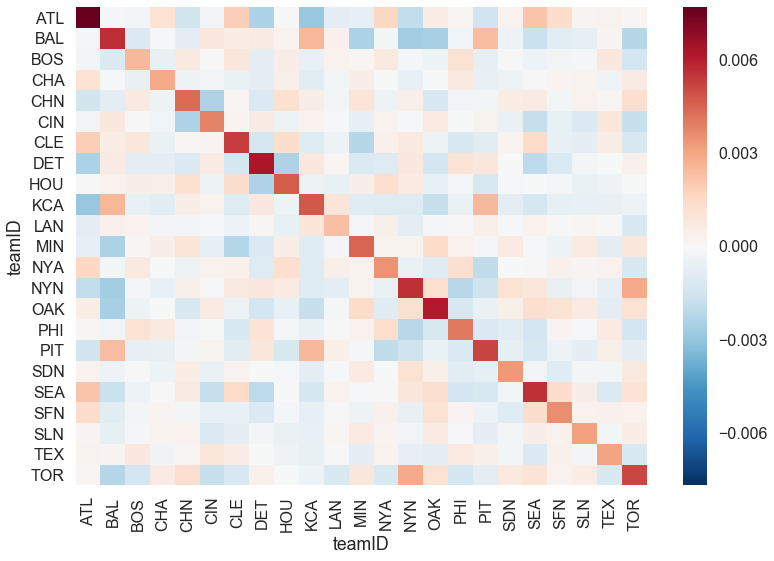

In [23]:
sns.heatmap(winP.cov())

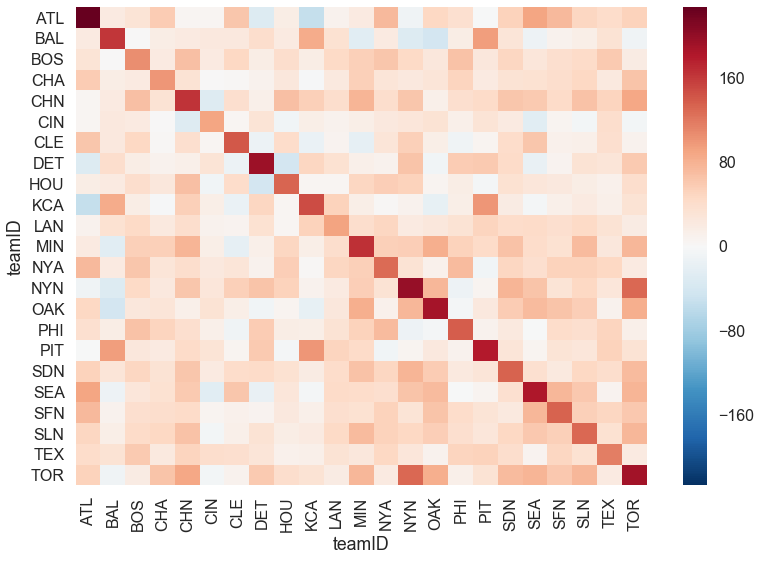

In [24]:
sns.heatmap(wins.cov())

In [25]:
corr = df.corr()
w, v = np.linalg.eig(corr)

In [26]:
df.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'G', 'Ghome', 'W', 'L',
       'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'doubles', 'triples',
       'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG',
       'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro', 'winP', 'singles'],
      dtype='object')

In [27]:
w

array([  1.04420752e+01,   6.39712416e+00,   5.17576434e+00,
         2.54705703e+00,   1.83067470e+00,   1.20410301e+00,
         1.09554299e+00,   8.58885462e-01,   7.60447372e-01,
         6.46245290e-01,   5.59813025e-01,   5.50571341e-01,
         4.54995821e-01,   4.29705376e-01,   4.04050512e-01,
         3.62016615e-01,   2.52853149e-01,   2.46625468e-01,
         1.80299821e-01,   1.58821809e-01,   1.19723438e-01,
         7.91263611e-02,   6.97635932e-02,   5.08412791e-02,
         4.06155199e-02,   2.47612433e-02,   1.79488135e-02,
         1.04076745e-02,   1.71104541e-04,   1.32852173e-03,
         2.12782726e-03,   3.17821667e-03,   8.81241171e-03,
         6.88348974e-03,   6.63797956e-03])

In [28]:
np.abs(quant.corr()['W'])

yearID        0.118944
G             0.470199
Ghome         0.465785
W             1.000000
R             0.647329
AB            0.493806
doubles       0.432862
triples       0.105263
HR            0.449693
BB            0.527244
SO            0.199785
SB            0.140549
CS            0.021255
HBP           0.158465
SF            0.163878
RA            0.179061
ER            0.155639
ERA           0.444766
CG            0.050751
SHO           0.488436
SV            0.649869
IPouts        0.512586
HA            0.091140
HRA           0.001948
BBA           0.085464
SOA           0.400000
E             0.111076
DP            0.129106
FP            0.315676
attendance    0.560515
BPF           0.079067
PPF           0.071565
winP          0.886517
singles       0.425792
Name: W, dtype: float64

In [31]:
valid = np.abs(quant.corr()['W'])<.6
valid.values

array([ True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True], dtype=bool)

In [35]:
vif = pd.DataFrame()

uncorrelated_cols = []
for i in range(0,len(valid)):
    if valid[i]:
        uncorrelated_cols.append(quant.columns[i])

vifQuants = quant[uncorrelated_cols].drop(['yearID'], axis=1)

vif["VIF Factor"] = [variance_inflation_factor(vifQuants.values, i) for i in range(vifQuants.shape[1])]
vif["features"] = vifQuants.columns
vif = vif.merge(columnDict, left_on='features', right_on='Column').drop('Column', axis=1)

vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features,Description
1,50888.650718,AB,At bats
24,27278.366363,BPF,Three-year park factor for batters
25,27041.139974,PPF,Three-year park factor for pitchers
0,24753.968360,G,Games played
12,13485.855928,ER,Earned runs allowed
22,8781.198165,FP,Fielding percentage
13,8544.408879,ERA,Earned run average
11,6368.404604,RA,Opponents runs scored
16,2112.048023,HA,Hits allowed
2,217.276057,doubles,Doubles


In [42]:
def calculate_vif_(X, thresh=1500):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [43]:
vifQuants.columns

Index(['G', 'Ghome', 'AB', 'doubles', 'triples', 'HR', 'BB', 'SO', 'SB', 'CS',
       'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'IPouts', 'HA', 'HRA',
       'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF', 'singles'],
      dtype='object')

In [44]:
excl = ['SHO']

In [45]:
result = calculate_vif_(vifQuants.drop(excl, axis=1))

dropping 'IPouts' at index: 16
dropping 'BPF' at index: 24
dropping 'AB' at index: 2
dropping 'G' at index: 0
dropping 'ER' at index: 11
dropping 'RA' at index: 10
dropping 'Ghome' at index: 0
Remaining variables:
Index(['doubles', 'triples', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'ERA',
       'CG', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'attendance', 'PPF',
       'singles'],
      dtype='object')


In [46]:
import time
import itertools

In [47]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    equation = "+".join(str(x) for x in list(feature_set))
    model = smf.ols('W~'+equation, data=quant).fit()
    mse = mean_squared_error(model.predict(quant[list(feature_set)]), quant['W'])
    return {"model":model, "R^2":model.rsquared, "Adj_R^2":model.rsquared_adj, "MSE": mse}

In [48]:
def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(result.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    models.head()
    
    # Choose the model with the highest Adjusted R^2
    best_model = models.loc[models['Adj_R^2'].argmax()]
    toc = time.time()
    
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [49]:
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in result.columns if p not in predictors]

    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest MSE
    best_model = models.loc[models['Adj_R^2'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [50]:
forward_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])
tic = time.time()
predictors = []
for i in range(1,len(result.columns)+1):
    forward_subset_models.loc[i] = forward(predictors)
    predictors = forward_subset_models.loc[i]["model"].model.exog_names
    predictors = [p for p in predictors if p not in ['Intercept']]
    
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")

Processed  21 models on 1 predictors in 0.24405884742736816 seconds.
Total elapsed time: 0.2478630542755127 seconds.
Processed  20 models on 2 predictors in 0.19971609115600586 seconds.
Total elapsed time: 0.4538397789001465 seconds.
Processed  19 models on 3 predictors in 0.3011598587036133 seconds.
Total elapsed time: 0.7592241764068604 seconds.
Processed  18 models on 4 predictors in 0.2746431827545166 seconds.
Total elapsed time: 1.043727159500122 seconds.
Processed  17 models on 5 predictors in 0.3082389831542969 seconds.
Total elapsed time: 1.3566861152648926 seconds.
Processed  16 models on 6 predictors in 0.3190889358520508 seconds.
Total elapsed time: 1.6804499626159668 seconds.
Processed  15 models on 7 predictors in 0.3330998420715332 seconds.
Total elapsed time: 2.0172219276428223 seconds.
Processed  14 models on 8 predictors in 0.34597182273864746 seconds.
Total elapsed time: 2.3696680068969727 seconds.
Processed  13 models on 9 predictors in 0.3439919948577881 seconds.
To

In [51]:
bestForward = forward_subset_models.iloc[forward_subset_models['MSE'].argmin()-1]['model']

In [52]:
bestForward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     290.7
Date:                Thu, 14 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:34:39   Log-Likelihood:                -2689.7
No. Observations:                 920   AIC:                             5423.
Df Residuals:                     898   BIC:                             5530.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    123.7525    268.668      0.461      0.645    -403.538     651.043
attendance  1.141e-06   2.85e-07      4.000      0.000    5.81e-07     1.7e-06
ERA          -12.7886      0.797    -16.047      0.000     -14.353     -11.224
HR             0.1510      0.006     24.631      0.000       0.139       0.163
singles        0.0484      0.003     14.944      0.000       0.042       0.055
BB             0.0354      0.003     13.755      0.000       0.030       0.040
doubles        0.0582      0.006      9.377      0.000       0.046       0.070
BBA           -0.0158      0.003     -5.088      0.000      -0.022      -0.010
triples        0.1125      0.018      6.362      0.000       0.078       0.147
E             -0.0750      0.044     -1.708      0.088      -0.161       0.011
SB             0.0275      0.006      4.904      0.000       0.016       0.038
HA            -0.0086      0.004     -2.423      0.016      -0.016      -0.002
SOA           -0.0013      0.002     -0.716      0.474      -0.005       0.002
SF            -0.0383      0.019     -2.040      0.042      -0.075      -0.001
HBP            0.0277      0.015      1.894      0.059      -0.001       0.056
SO            -0.0015      0.002     -0.882      0.378      -0.005       0.002
CG             0.0162      0.019      0.832      0.406      -0.022       0.054
HRA           -0.0065      0.009     -0.695      0.488      -0.025       0.012
DP             0.0059      0.010      0.574      0.566      -0.014       0.026
PPF           -0.0129      0.038     -0.338      0.735      -0.088       0.062
FP           -72.4008    271.954     -0.266      0.790    -606.140     461.338
CS            -0.0018      0.015     -0.120      0.904      -0.031       0.028
==============================================================================
Omnibus:                        1.028   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                1.085
Skew:                           0.037   Prob(JB):                        0.581
Kurtosis:                       2.849   Cond. No.                     5.87e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
forward_subset_models.iloc[forward_subset_models['MSE'].argmin()-1]

R^2                                                 0.871773
Adj_R^2                                             0.868774
MSE                                                  20.2732
model      <statsmodels.regression.linear_model.Regressio...
Name: 21, dtype: object

In [303]:
best_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])

tic = time.time()

for i in range(1,len(result)):
    best_subset_models.loc[i] = getBest(i)
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")

Processed  24 models on 1 predictors in 0.23946595191955566 seconds.
Total elapsed time: 0.24303293228149414 seconds.
Processed  276 models on 2 predictors in 2.636281967163086 seconds.
Total elapsed time: 2.8833799362182617 seconds.
Processed  2024 models on 3 predictors in 25.885746955871582 seconds.
Total elapsed time: 28.773334980010986 seconds.
Processed  10626 models on 4 predictors in 169.20321702957153 seconds.
Total elapsed time: 197.98769998550415 seconds.


KeyboardInterrupt: 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    result, quant['W'], test_size=0.33, random_state=42)

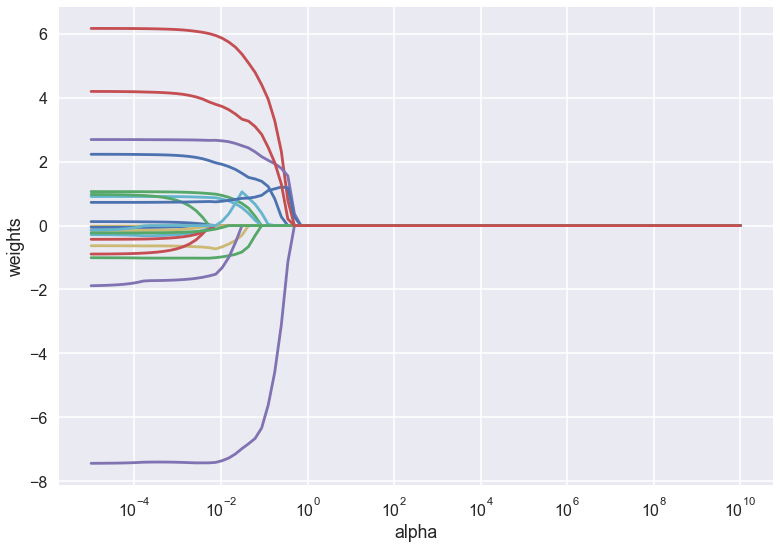

In [55]:
lasso = Lasso(max_iter=10000, normalize=True)
alphas = 10**np.linspace(10, -5, 100) * 0.5

coeffs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train), y_train)
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas * 2, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

plt.show()

In [56]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mseLasso = mean_squared_error(y_test, lasso.predict(X_test))
print(pd.Series(lasso.coef_, index=X_test.columns))
print('Lasso Test MSE: ' + str(mseLasso))

doubles       4.896903e-02
triples       9.905598e-02
HR            1.456498e-01
BB            3.361214e-02
SO           -3.779960e-03
SB            2.363984e-02
CS            0.000000e+00
HBP           0.000000e+00
SF           -0.000000e+00
ERA          -1.373768e+01
CG            0.000000e+00
HA           -0.000000e+00
HRA          -0.000000e+00
BBA          -1.370799e-02
SOA          -0.000000e+00
E            -6.393716e-02
DP           -0.000000e+00
FP            3.836710e+00
attendance    9.872515e-07
PPF          -2.376450e-02
singles       4.056776e-02
dtype: float64
Lasso Test MSE: 22.9909030594
